In [146]:
from aiida import load_profile 
load_profile()
import os
from glob import glob
from pathlib import Path
import click
import pandas as pd
import pickle
from ase.io import read, write
from aiida.engine import WorkChain
from aiida.orm import Dict
from aiida.orm.querybuilder import QueryBuilder
from aiida.plugins import DataFactory, CalculationFactory
Cp2kCalculation = CalculationFactory('cp2k')
from water_isotherm_workchains.utils.utils import slugify
from aiida.orm import load_node
CifData = DataFactory('cif')
StructureData = DataFactory('structure')
from datetime import datetime, timedelta

## Scalings

In [247]:
def query_structure(structure_label='KISXIU', nodes=1):
    qb = QueryBuilder()
    qb.append(
        StructureData, tag='inp_struct', filters={'label': structure_label}, project=['uuid']
    )
    qb.append(
        WorkChain,
        filters={'label': 'scaling_test_'+str(nodes)},
        tag='wc',
        with_incoming='inp_struct',
        project=['uuid'],
    )
    qb.append(
        WorkChain,
        project=['uuid'],
    )
    
    qb.append(
        Cp2kCalculation,
        project=['uuid'],
    )
    return qb.all()


In [248]:
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

parsed_results = []

for name in ['KISXIU']:
    for nodes in [1, 2, 4, 8, 12, 16, 32]:
        res = query_structure(name, nodes)
        for r in res:
            cp2kcalc = load_node(r[-1])
            stdout = cp2kcalc.get_scheduler_stdout().split('\n')
            t = datetime.strptime(stdout[5].split()[-2], '%H:%M:%S').time()
            parsed_results.append(
                {
                    'name': name, 
                    'nodes': nodes,
                    'time': timedelta(hours=t.hour, minutes=t.minute, seconds=t.second).total_seconds()
                }
            )

In [249]:
df = pd.DataFrame(parsed_results)

In [250]:
df['speedup'] = df[df['nodes']==1]['time'].values[0] / df['time'] 
df['ratio_from_ideal'] = df['speedup'] / df['nodes']

In [251]:
import seaborn as sns

Text(0, 0.5, 'speedup')

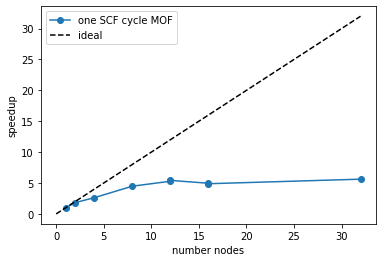

In [252]:
plt.plot(df['nodes'], df['speedup'], label='one SCF cycle MOF', marker='o')
plt.plot([0,32], [0,32], '--k', label='ideal')
plt.legend()
plt.xlabel('number nodes')
plt.ylabel('speedup')

In [253]:
df

,name,nodes,time,speedup,ratio_from_ideal
0,KISXIU,1,1862.0,1.000000,1.000000
1,KISXIU,2,1018.0,1.829077,0.914538
2,KISXIU,4,710.0,2.622535,0.655634
3,KISXIU,8,415.0,4.486747,0.560843
4,KISXIU,12,352.0,5.289773,0.440814
5,KISXIU,12,343.0,5.428571,0.452381
6,KISXIU,16,375.0,4.965333,0.310333
7,KISXIU,16,381.0,4.887139,0.305446
8,KISXIU,32,331.0,5.625378,0.175793
